# Difference Image Analysis Tutorial

This notebook shows how to run image subtraction using [dia_pipe](https://github.com/LSSTDESC/dia_pipe) on a single image pair. Association and forced photometry are not discussed here.

### Download prerequisite packages.

- [obs_lsst](https://github.com/lsst/obs_lsst)
- [dia_pipe](https://github.com/LSSTDESC/dia_pipe)

Let us create a working directory called `dia_tutorial`, and download `obs_lsst` and `dia_pipe` to the `dia_tutorial` using git clone.

### Setup

Next, create a script in the `dia_tutorial` with the following content in it. Here we name the script as `setup.sh`

```
#！/bin/bash

source /cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/v20.0.0/loadLSST.bash

setup lsst_distrib

# scons only need to be done once. We cannot comment out the following three lines after the first running. setup -jr dia_pipe need to be kept.
cd dia_pipe
scons
cd ..
setup -jr dia_pipe

export HDF5_USE_FILE_LOCKING=FALSE
export OMP_NUM_THREADS=1

echo 'done'
```

After creating the `setup.sh`. Open a terminal, `cd` to the `dia_tutorial` directory, and run `source ./setup.sh`

### DC2 Dataset

We use [DC2](https://arxiv.org/abs/2010.05926) dataset to performa difference imaging. We use the calexp exposure as the science image and the coadd exposure as the template image. A calexp exposure is identified by its `visit` and `detector`. A coadd exposure is identified by its `tract`, `patch`, and `filter`. When running `imageDifferenceDriver.py` of the `dia_pipe`, we need to speficy the calexp exposure. The pipeline will match the coadds which overlap with the calexp and resample the coadds to create a template which has the same orientation of the calexp.

### Performing Image Differencing

Both the [AL](https://arxiv.org/abs/astro-ph/9712287) algorithm and the [ZOGY](https://arxiv.org/abs/1601.02655) algorithm have been implemented in the `dia_pipe`.

#### AL algorithm

$N = \kappa \otimes R, \quad \kappa = \Sigma x^ly^m \times e^{-(u^2 + v^2) / (2\sigma_n^2)}u^{i_n}v^{j_n}.$

To run the AL algorithm, we need to write a config file (`diffimConfig_al.py`) in the `dia_tutorial` directory with the following content in it.
```
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask
config.imageDifference.refObjLoader.retarget(LoadIndexedReferenceObjectsTask)
config.imageDifference.refObjLoader.load('obs_lsst/config/filterMap.py')
config.imageDifference.kernelSourcesFromRef = True
config.ccdKey = 'detector'
```
This config will enable the defaut AL algorithm. Below are some configs for adjusting the behavior of the pipeline. We can add them to the config file if we want more variability of the algorithm.
```
config.imageDifference.detection.thresholdValue = 5.5
config.imageDifference.subtract['al'].kernel['AL'].spatialKernelOrder=4
config.imageDifference.subtract['al'].kernel['AL'].usePcaForSpatialKernel=False

# Number of base Gaussians in alard-lupton kernel basis function generation.
config.imageDifference.subtract['al'].kernel['AL'].alardNGauss=4

# Polynomial order of spatial modification of base Gaussians. List length must be `alardNGauss`.
config.imageDifference.subtract['al'].kernel['AL'].alardDegGauss=[2, 4, 2, 2]

# Default sigma values in pixels of base Gaussians. List length must be `alardNGauss`.
config.imageDifference.subtract['al'].kernel['AL'].alardSigGauss=[0.1, 0.7, 1.5, 3.0]

config.imageDifference.subtract['al'].kernel['AL'].usePcaForSpatialKernel=False

# Convolve science image by its PSF before PSF-matching?
config.imageDifference.doPreConvolve=False
# Use a simple gaussian PSF model for pre-convolution (else use fit PSF)? Ignored if doPreConvolve false.
config.imageDifference.useGaussianForPreConvolution=False

# Perform diffim decorrelation to undo pixel correlation due to A&L kernel convolution? If True, also update the diffim PSF.
config.imageDifference.doDecorrelation = False
# If using Zogy or A&L decorrelation, perform these on a grid across the image in order to allow for spatial variations
config.imageDifference.doSpatiallyVarying = False

config.imageDifference.convolveTemplate = True
config.imageDifference.doDeblend = True
```

After writing the `diffimConfig_al.py`) in the `dia_tutorial` directory, we can run the following code in the terminal, which will create a difference image and a detection table for the calexp with data id (visit=1013665 detector=79 filter=i)
```
imageDifferenceDriver.py /global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-grizy \
    --output test_al \
    --id visit=1013665 detector=79  -C diffimConfig_al.py \
    --clobber-config --clobber-versions --cores 4
```
Here `/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-grizy` is the repo of the dataset. `--output` speficy the directory of the difference image. `-C` specify the config file.

#### slurm
If we are running multiple subtractions, our script will take too much time. If it needs more than 24 hours, we can use [slurm](https://docs.nersc.gov/jobs/) to run image differencing.
Using slurm requires the user to set the running time, which is hard to estimate. Below is a simple example which works for single subtractions.

To begin with, we need to create a directory called `logs_folder` in the `dia_tutorial` directory.

Next, we run the following code in terminal.

```
imageDifferenceDriver.py /global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-grizy \
    --output test_al_slurm \
    --id visit=1013665 detector=79  -C diffimConfig_al.py \
    --clobber-config --clobber-versions --cores 1 \
    --batch-type=slurm \
    --time 5000 \
    --mpiexec='-bind-to socket' \
    --batch-output logs_folder \
    --batch-options='-C haswell -q shared'
```
We can use `squeue -u username` to check the progrerss.

#### ZOGY algorithm

To run the ZOGY algorithm, we need the following config.

`diffimConfig_zogy.py`
```
import os
from lsst.utils import getPackageDir
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask
from lsst.ip.diffim.getTemplate import GetCalexpAsTemplateTask

config.imageDifference.refObjLoader.retarget(LoadIndexedReferenceObjectsTask)
config.imageDifference.refObjLoader.load(os.path.join(getPackageDir('obs_lsst'), 'config', 'filterMap.py'))
config.imageDifference.kernelSourcesFromRef = True
config.ccdKey = 'detector'
config.imageDifference.subtract='zogy'
config.imageDifference.subtract['zogy'].zogyConfig.inImageSpace=False
```

The image subtraction code should also be modified as following

```
imageDifferenceDriver.py /global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-grizy \
    --output test_zogy \
    --id visit=1013665 detector=79  -C diffimConfig_zogy.py \
    --clobber-config --clobber-versions --cores 4
```
We should also be careful of where we are running the slurm. Because not all spaces on nersc support slurm. (cscratch1 works)

### Analysis

We use the data product from the AL algorithm for analysis.

There are two popular methods to read the data product. One is to use [Butler](https://github.com/lsst/obs_lsst/blob/w.2019.19_diff/policy/lsstCamMapper.yaml) (slow), the other is to read directly from the path.

In [1]:
# use butler
from lsst.daf.persistence import Butler

diff_repo = './test_al/'
diff_butler = Butler(diff_repo)
# get difference exposure
diff_id = {'visit': 1013665, 'detector': 79, 'filter': 'i'}
diff_exp = diff_butler.get('deepDiff_differenceExp', diff_id)
# get diaSrc table (detection table)
diff_diaSrc = diff_butler.get('deepDiff_diaSrc', diff_id)
# we can also change the diaSrc table to an astropy table
# diff_diaSrc_astropy = diff_diaSrc.asAstropy()

In [2]:
# read directly from the path
import lsst.afw.image as afwImage
from lsst.afw.table import BaseCatalog

diff_exp = afwImage.ExposureF('./test_al/deepDiff/v01013665-fi/R20/diffexp_01013665-i-R20-S21-det079.fits')
diff_diaSrc = BaseCatalog.readFits('./test_al/deepDiff/v01013665-fi/R20/diaSrc_01013665-i-R20-S21-det079.fits')
diff_diaSrc_astropy = diff_diaSrc.asAstropy()

In [3]:
# get the image, variance, mask, bounding box, wcs  
# diff_exp.getImage().array
# diff_exp.getVariance().array
# diff_exp.getMask().array
# diff_exp.getBBox()
# diff_exp.getWcs()

# psf 
diff_psf = diff_exp.getPsf()
# get psf array
# diff_psf.computeImage().array.shape
# psf width
psf_shape = diff_psf.computeShape()
# second order moment
# ixx = psf_shape.getIxx()
# iyy = psf_shape.getIyy()
# Gaussian sigma and fwhm
# sigma = np.sqrt(( ixx + iyy) / 2 )
# fwhm = 2.355 * sigma

In [4]:
# calibration
# usee Butler
# diff_photoCalib = diff_butler.get('deepDiff_differenceExp_photoCalib', diff_id)
# use difference exposure
diff_photoCalib = diff_exp.getPhotoCalib()

# convert the instrumental flux to magnitude
inst_flux = diff_diaSrc['base_PsfFlux_instFlux']
inst_flux_err = diff_diaSrc['base_PsfFlux_instFluxErr']
mag_with_error = diff_photoCalib.instFluxToMagnitude(inst_flux[1], inst_flux_err[1])
print(mag_with_error)
mag = diff_photoCalib.instFluxToMagnitude(inst_flux[1])
print(mag)
# convert the instrumental flux to nanojansky
nanojansky = diff_photoCalib.instFluxToNanojansky(inst_flux[1], inst_flux_err[1])
print(nanojansky)

# diaSrc table has many importmant measurements, such as
# pixel coordiantes: base_NaiveCentroid_x, base_NaiveCentroid_y
# sky coordinates: coord_ra, coord_dec

value=17.28362684298275553, error=0.00487471151148300124
17.283626842982756
value=443148.4787702015019, error=1989.637060356218171


### Display cutout

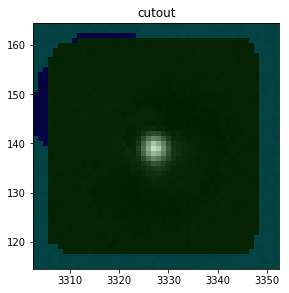

In [12]:
import lsst.geom as geom
import matplotlib.pyplot as plt
import lsst.afw.display as afwDisplay

# pick a pixel coordinate
x, y = diff_diaSrc['base_NaiveCentroid_x'][1], diff_diaSrc['base_NaiveCentroid_y'][1]
cutout_size=50
cutout_extent = geom.ExtentI(cutout_size, cutout_size)
radec = geom.SpherePoint(diff_exp.getWcs().pixelToSky(x, y))
cutout_exp = diff_exp.getCutout(radec, cutout_extent)
xy = geom.PointI(x, y)
afwDisplay.setDefaultBackend('matplotlib')
display = afwDisplay.Display(frame=None)
display.mtv(cutout_exp)
plt.title('cutout')
print()

In [16]:
# show color code
mask = diff_exp.getMask()
dsp = afwDisplay.Display()
for maskName, maskBit in mask.getMaskPlaneDict().items():
    print('{}: {}'.format(maskName, dsp.getMaskPlaneColor(maskName)))

BAD: red
BRIGHT_OBJECT: None
CLIPPED: None
CR: magenta
CROSSTALK: None
DETECTED: blue
DETECTED_NEGATIVE: cyan
EDGE: yellow
INEXACT_PSF: None
INTRP: green
NOT_DEBLENDED: None
NO_DATA: orange
REJECTED: None
SAT: green
SENSOR_EDGE: None
SUSPECT: yellow
UNMASKEDNAN: None


<Figure size 432x288 with 0 Axes>

### Reading calexp and coadd information

In [67]:
# get calexp Butler
calexp_repo = '/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-calexp-v1'
calexp_butler = Butler(calexp_repo)

# get exp and photocalib
calexp_id = {'visit': 1013665, 'detector': 79, 'filter': 'i'}
calexp_exp = calexp_butler.get('calexp', calexp_id)
calexp_photocalib = calexp_butler.get('calexp_photoCalib', calexp_id)
# get the source table measured from the calexp exposure
calexp_src = calexp_butler.get('src', calexp_id)

In [65]:
# get coadd Butler
coadd_repo = '/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-grizy'
coadd_butler = Butler(coadd_repo)

# get expo and photocalib
coadd_id = {'tract': 4639, 'patch': '0,0', 'filter': 'i'}
coadd_exp = coadd_butler.get('deepCoadd', coadd_id)
coadd_photocalib = coadd_butler.get('deepCoadd_photoCalib', coadd_id)

### Getting the nearest coadd coadd id with a given calexp exposure

In [85]:
calexp_wcs = calexp_exp.getWcs()
print(calexp_wcs)

FITS standard SkyWcs:
Sky Origin: (57.076576, -31.143652)
Pixel Origin: (2098.29, 1852.97)
Pixel Scale: 0.199748 arcsec/pixel


In [121]:
# use sky origin as the center of the calexp
sky_origin = calexp_wcs.getSkyOrigin()
# use skymap to match the coadd
skymap = coadd_butler.get("deepCoadd_skyMap")
tract_info = skymap.findTract(sky_origin)
patch_info = tract_info.findPatch(sky_origin)
patch_idx = patch_info.getIndex()

coadd_id = {'tract': tract_info.getId(), 
                'patch': f'{patch_idx[0]},{patch_idx[1]}' }
print(coadd_id)

{'tract': 4639, 'patch': '0,0'}


### Getting the calexp information with a given coadd

In [127]:
import sqlite3
import pandas as pd

# use the tracts_mapping.sqlite3 data base
db = '/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-calexp-v1/tracts_mapping.sqlite3'
conn = sqlite3.connect(db)

tract = 4639
# here patch is a tuple
patch = (0, 0)
filt = 'i'
query = (f"select distinct(visit), filter, detector, tract, patch from overlaps where tract={tract} " 
         f"and patch='{patch}' and filter='{filt}' order by visit")
calexp_info = pd.read_sql_query(query, conn)

### Forced photometry

The `dia_pipe` can perform forced photometry by providing `id`, `coord_ra` (in radian), and `coord_dec` (in radian). This method is available in branch `origin/#19`. To setup this branch, we need to change the setup file as following.

`setup.sh`
```
#！/bin/bash

source /cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/v20.0.0/loadLSST.bash

setup lsst_distrib

# scons only need to be done once. We cannot comment out the following three lines after the first running. setup -jr dia_pipe need to be kept.
# cd dia_pipe
# git checkout origin/#19
# scons
# cd ..
setup -jr dia_pipe

export HDF5_USE_FILE_LOCKING=FALSE
export OMP_NUM_THREADS=1

echo 'done'
```

After running `source setup.sh` in the `dia_tutorial` directory, we create the config file for the forced photometry. Let us call this config file as `forcedConfig.py`. We can set the aperture radii in the config.


```
config.measurement.plugins.names |= ["base_CircularApertureFlux"]
# radii in pixels
config.measurement.plugins["base_CircularApertureFlux"].radii = [1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 20.0, 30.0, 40.0]
```

In [21]:
# Next, we create the coordinate table
coord = diff_diaSrc_astropy[['id', 'coord_ra', 'coord_dec']]
coord.write('coord.fits', format='fits', overwrite=True)

Now we can run the `forcedPhotCatalogDia.py` as following.
```
forcedPhotCatalogDia.py /global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-grizy \
    --output test_al \
    --id visit=1013665 detector=79 \
    -c catalogName=coord.fits outputDir=forced -C forcedConfig.py \
    --clobber-versions --clobber-config
```

In [31]:
# read forced photometry table
forced_table = BaseCatalog.readFits('./forced/forced_1013665_79.fits')
forced_astropy  = forced_table.asAstropy()

# merge diaSrc table and forced photometry table using pandas

import pandas as pd
diff_diaSrc_pd = diff_diaSrc_astropy.to_pandas()
forced_pd = forced_astropy.to_pandas()
joint_table = diff_diaSrc_pd.merge(forced_pd, left_on='id', right_on='dia_object_id',
                                 suffixes=['_diaSrc', '_forced'])

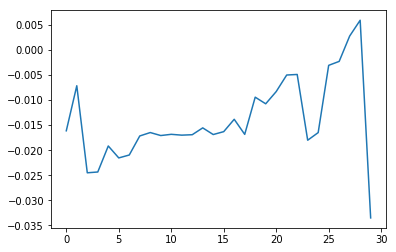

In [32]:
# calculate flux residuals
forced_flux = joint_table['base_PsfFlux_instFlux_forced']
diaSrc_flux = joint_table['base_PsfFlux_instFlux_diaSrc']
res = (forced_flux - diaSrc_flux) / diaSrc_flux
plt.plot(res)

### Reference

- [Butler data types](https://github.com/lsst/obs_lsst/blob/w.2019.19_diff/policy/lsstCamMapper.yaml)